Прежде всего установим библиотеки, которые понадобятся нам для работы с нейронками:

keras - высокоуровневый фреймворк работы с нейронными сетями. Пожалуй, он имеет самый низкий порог входа среди всех библиотек подобного рода, поэтому для нашего курса выбран именно он
tensorflow - это одна из библиотек "бэкэнда" нейронных сетей. Это то, что keras будет использовать у себя "под капотом"

In [1]:
!pip install keras

In [2]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 5.3 MB/s 


Следующая команда покажет название видеокарты, подходящей для использования при обучении нейронок (если такой нет - ничего не выведет)

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Видим, что видеокарта не подключена. Работая в Google Colab, мы можем подключить видеокарту с небольшим запасом бесплатного времени использования, выполнив несколько нехитрых действий. Для нашего задания необязательно использовать видеокарту, но потренироваться в ее использовании будет полезно.

Для того, чтобы подключить ядро с видеокартой, нам понадобится переключить окружение питона. Для этого нажмите `Среда выполнения -> Сменить среду выполнения` и там выберите Аппаратный ускоритель GPU.
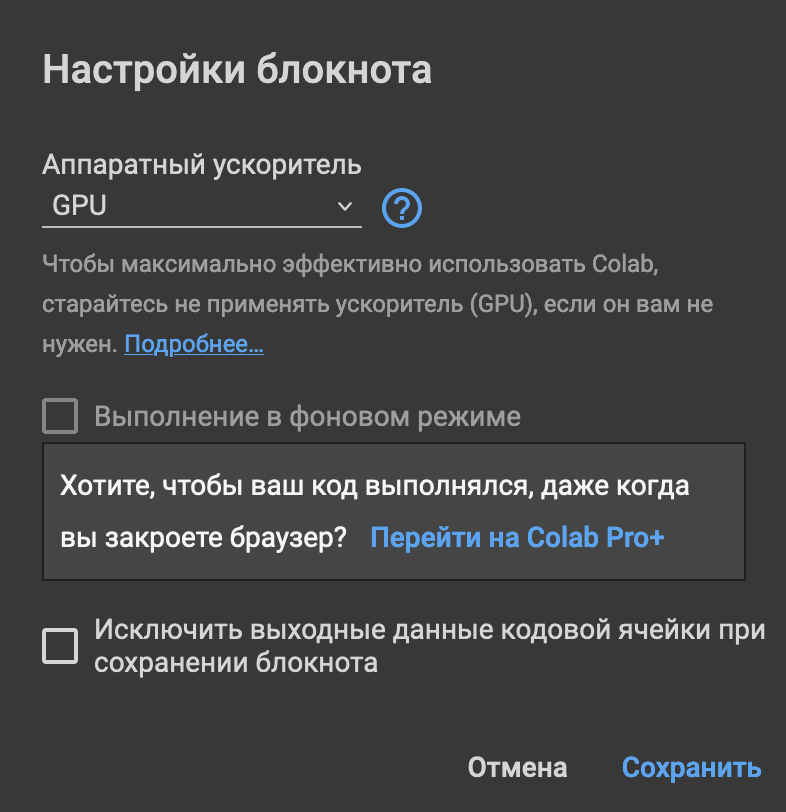

Теперь повторим код из предыдущей ячейки и увидим, что нам доступна видеокарта.

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Уточним, используется ли сейас графический процессор:

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

Если предыдущая ячейка вывела что-то вроде `/device:GPU:0`, то tensorflow использует видеокарту. Теперь начнем работу над нейронкой.

In [6]:
import numpy as np
np.random.seed(123)  # для воспроизводимости
from keras.models import Sequential                           # Sequential - это базовый класс нейронки в керасе
from keras.layers import Dense, Dropout, Activation, Flatten  # дальше импортируем классы слоев
from keras.layers import Convolution2D, MaxPooling2D          # еще немного слоев, которые предназначены именно для работы с картинками
from keras.utils import np_utils
from keras.datasets import mnist                              # а это - классический набор картинок с рукописными цифрами, которые мы будем
                                                              # классифицировать в нашем примере

# Подготовка к выполнению заданий

Датасет с картинками достаточно большой, поэтому было бы слишком накладно хранить его в гите. Скачаем архив с фотографиями для задания и разархивируем его в нашу рабочую папку.

In [7]:
# загрузим архив с фотографиями во временную папку /tmp/ и назовем его dataset.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/dataset.zip

--2022-04-18 14:57:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.193.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>]  65.43M   228MB/s    in 0.3s    

2022-04-18 14:57:51 (228 MB/s) - ‘/tmp/dataset.zip’ saved [68606236/68606236]



In [8]:
import shutil
import zipfile

local_zip = '/tmp/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/tmp/dataset")
!mkdir dataset
!mv /tmp/dataset/cats_and_dogs_filtered/train/* dataset/
!mv /tmp/dataset/cats_and_dogs_filtered/validation/cats/* dataset/cats/
!mv /tmp/dataset/cats_and_dogs_filtered/validation/dogs/* dataset/dogs/
!rm -rf /tmp/dataset
!rm -rf /tmp/dataset.zip

# Задание 1. Готовим обучающую выборку

Нам требуется подготовить модель, которая разделяет фотографии на две категории, в зависимости от того, что на них нарисовано. Будем использовать сверточную нейросеть для этого.

У нас есть набор фотографий кошек и собак. Подготовим нейронку, которая будет уметь классифицировать фотографии на те, на которых изображена кошка, и те, на которых изображена собака.

Структура папки с фотографиями следующая:
```
dataset
|- cats
|- dogs
```
Разделите изображения на тренировочную и тестовую выборки в соотношении 80/20. Сохраните их в соответствии со следующей структурой папок:
```
dataset/animals
|- train
|  |- cats
|  |- dogs
|
|- test
|  |- cats
|  |- dogs
```

In [9]:
!ls dataset

cats  dogs


В этой работе мы будем использовать нейросеть определенного типа - VGG19 с весами ResNet, параметры изображений для которой зададим заранее.

In [10]:
import numpy as np
np.random.seed(123)  # для воспроизводимости
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator

In [11]:
import os

# размер для ResNet'a
img_width, img_height = 224, 224

# корневая папка
root_dir = '/content/dataset'  # введите сюда адрес корневой папки
# os.path.join(path1[, path2[, ...]]) соединяет пути с учётом особенностей операционной системы
# папка с тренировочными картинками
train_dir = os.path.join(root_dir, 'animals', 'train')
# try:
#   os.stat(train_dir)
# except:
#   os.makedirs(train_dir)
# и папка с тестовыми
test_dir = os.path.join(root_dir, 'animals', 'test')
# try:
#   os.stat(test_dir)
# except:
#   os.makedirs(test_dir)
# размер батча
batch_size = 16

In [12]:
# if not os.path.exists('/content/dataset/animals/train/cats'):
#     train_cats = os.makedirs('/content/dataset/animals/train/cats')
# if not os.path.exists('/content/dataset/animals/train/dogs'):
#     train_dogs = os.makedirs('/content/dataset/animals/train/dogs')
# if not os.path.exists('/content/dataset/animals/test/cats'):
#     train_cats = os.makedirs('/content/dataset/animals/test/cats')
# if not os.path.exists('/content/dataset/animals/test/dogs'):
#     train_dogs = os.makedirs('/content/dataset/animals/test/dogs')

Сымитируем ситуацию, когда нам регулярно приходят новые изображения, и нам нужно дообучать модель. Поэтому для раскладывания картинок по папкам нужно написать функцию. Очищать исходные папки не нужно.

In [13]:
def train_test_split_images_dir(root_folder: str, folder_name: str):
    src = root_folder + '/' + folder_name
    list_f = os.listdir(src)
    dst_train = root_folder + '/animals/train/' + folder_name
    dst_test = root_folder + '/animals/test/' + folder_name

    if not os.path.exists(dst_train):
      os.makedirs(dst_train)
    if not os.path.exists(dst_test):
      os.makedirs(dst_test)
      
    for i, file_ in enumerate(list_f):
      if i < len(list_f) * 0.8:
        shutil.copyfile(src + '/' + file_, dst_train + '/' + file_)
      else:
        shutil.copyfile(src + '/' + file_, dst_test + '/' + file_)

def train_test_split_images(root_folder: str):
    """функция принимает аргумент - адрес корневой папку с изображениями,
    берет изображения из подпапок этой папки и раскладывает по папкам
    из описания задания"""
    # решение задания 1

    if os.path.exists(root_folder + '/animals'):
        shutil.rmtree(root_folder + '/animals')
    list_d = os.listdir(root_folder)
    if not os.path.exists(root_folder + '/animals'):
        os.makedirs(root_folder + '/animals')
    if not os.path.exists(root_folder + '/animals/train'):
        os.makedirs(root_folder + '/animals/train')
    if not os.path.exists(root_folder + '/animals/test'):
        os.makedirs(root_folder + '/animals/test')

    for dir in list_d:
        if (os.path.isdir(root_folder + '/' + dir)):
            train_test_split_images_dir(root_folder, dir)

In [14]:
train_test_split_images('/content/dataset')

In [15]:
os.listdir('/content/dataset/animals')

['train', 'test']

В фотографиях, с которыми придется иметь дело нейросети, кошки и собаки могут быть абсолютно разные, сфотографированные под разными углами и с разной степенью приближения. Имея конечную тренировочную выборку, мы можем ее расширить, поворачивая и приближая имеющиеся изображения. В этом нам поможет класс [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,  # приведем значения пикселей к 0-1
    shear_range=0.2,   # максимальный угол поворота изображений
    zoom_range=0.2,    # максимальное приближение изображений
    horizontal_flip=True)  # используем повороты изображений для обогащения обучающей выборки

test_datagen = ImageDataGenerator(rescale=1. / 255)  # замер качества мы должны проводить на оригинальных изображениях, 
                                                     # поэтому тестовую выборку мы не будем вращать и приближать

Далее считаем изображения из папки, приведя их к тому размеру, с которым работает сеть VGG19. Кстати говоря, преимущество ImageDataGenerator'а в том, что картинки, разложенные по подпапкам, автоматически считаются объектами разных классов.

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# создайте генератор для тестовой выборки
test_generator =  test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Задание 2. Переиспользование топологий нейронных сетей

Построим модель. Ваша задача - найти в интернете архитектуру VGG19 и описать нейросеть по этой архитектуре через keras. Рекомендую ориентироваться на архитектуру, описанную в официальном репозитории кераса на github.com. Ссылку на него здесь не приведена сознательно, поскольку большая часть работы программиста заключается в умении гуглить, и этот навык лучше тренировать сразу.

In [18]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import data_utils
import cv2, numpy as np
from keras.utils import data_utils

model = Sequential()
# продолжайте построение сети - задание 2

model.add(Convolution2D(64, 3, 1, activation='relu', input_shape=(224,224,3)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same', name='block1_pool'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block2_pool'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block3_pool'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block4_pool'))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block5_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 zero_padding2d (ZeroPadding  (None, 224, 224, 64)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 224, 224, 64)     0         
 ng2D)                                                           
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 114, 114, 64)     0

In [19]:
# !find / -name "vgg19_weights_tf_dim_ordering_tf_kernels.h5"
# !cp /root/.keras/models/vgg19_weights_tf_dim_ordering_tf_kernels.h5 /content/dataset

In [20]:
# def vlg_34():
#     from keras import backend
#     from keras.applications import imagenet_utils
#     from keras.engine import training
#     from keras.layers import VersionAwareLayers
#     from keras.utils import data_utils
#     layers = VersionAwareLayers()
#     input_shape = imagenet_utils.obtain_input_shape(
#         None,default_size=224,min_size=32,
#         data_format=backend.image_data_format(),
#         require_flatten=True,weights='imagenet')
#     img_input = layers.Input(shape=input_shape)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
#     x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
#     x = layers.Flatten(name='flatten')(x)
#     x = layers.Dense(4096, activation='relu', name='fc1')(x)
#     x = layers.Dense(4096, activation='relu', name='fc2')(x)
#     imagenet_utils.validate_activation('softmax', 'imagenet')
#     x = layers.Dense(1000, activation='softmax',
#                         name='predictions')(x)
#     model2 = training.Model(img_input, x, name='vgg19')
#     model2.load_weights(data_utils.get_file(
#             'vgg19_weights_tf_dim_ordering_tf_kernels.h5',
#             'https://storage.googleapis.com/tensorflow/keras-applications/'
#                 'vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5',
#             cache_subdir='models',
#             file_hash='cbe5617147190e668d6c5d5026f83318'))
#     return model2
# model = Sequential()
# model.add(vlg_34())
# model.add(Dense(2, activation='softmax'))
# model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
# model.save_weights(os.path.join(root_dir,'vgg19_weights_tf_dim_ordering_tf_kernels.h5'))

Подгрузим веса модели, подобранные экспертами до нас. Если на предыдущем этапе вы создали неправильную архитектуру, следующая ячейка упадет с ошибкой.

In [21]:
# model.load_weights(os.path.join(root_dir, 'vgg19_weights_tf_dim_ordering_tf_kernels.h5'))
model.load_weights(data_utils.get_file(
            'vgg19_weights_tf_dim_ordering_tf_kernels.h5',
            'https://storage.googleapis.com/tensorflow/keras-applications/'
                'vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5',
            cache_subdir='models',
            file_hash='cbe5617147190e668d6c5d5026f83318'))

574726144/574710816 [==============================] - 11s 0us/step


Осталось добавить полносвязный слой из двух нейронов (по количеству наших классов) с функцией активации softmax, чтобы наша модель могла производить бинарную классификацию изображений.

In [22]:
model.add(Dense(2, activation='softmax'))  # добавьте полносвязный слой, состоящий из двух нейронов, с функцией активации softmax

Скомпилируем и обучим сеть. Поскольку данные у нас теперь будут подаваться через генераторы, обучать модель нужно не методом fit, а методом fit_generator.

In [23]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# для примера обучим одну эпоху
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=250 // batch_size,
#     epochs=1,
#     workers=3)

In [24]:
model.save_weights(os.path.join(root_dir,'vgg19_weights_tf_dim_ordering_tf_kernels.h5'))

# Задание 3. Обучение сети

Обучите 20 эпох сети, замеряя качество после каждой эпохи. Постройте график зависимости качества классификации от количества эпох сети. На какой эпохе качество модели превысит 0.45?

In [25]:
# решение задания 3

scores = {}
for n_epochs in range(1, 31):  
    model.fit_generator( train_generator, steps_per_epoch=250 // batch_size, epochs=n_epochs, workers=3, initial_epoch=n_epochs-1)
    score = model.evaluate(x=test_generator, workers=3, verbose=0)
    scores[n_epochs] = score  # сохраним текущее качество, чтобы построить график

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


15/15 [==============================] - 26s 643ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 2/2
15/15 [==============================] - 10s 637ms/step - loss: 0.6933 - accuracy: 0.4792
Epoch 3/3
15/15 [==============================] - 11s 642ms/step - loss: 0.6929 - accuracy: 0.5292
Epoch 4/4
15/15 [==============================] - 11s 638ms/step - loss: 0.6930 - accuracy: 0.5167
Epoch 5/5
15/15 [==============================] - 10s 638ms/step - loss: 0.6926 - accuracy: 0.5333
Epoch 6/6
15/15 [==============================] - 10s 643ms/step - loss: 0.6941 - accuracy: 0.4542
Epoch 7/7
15/15 [==============================] - 10s 639ms/step - loss: 0.6929 - accuracy: 0.5250
Epoch 8/8
15/15 [==============================] - 10s 641ms/step - loss: 0.6931 - accuracy: 0.5083
Epoch 9/9
15/15 [==============================] - 10s 642ms/step - loss: 0.6935 - accuracy: 0.4875
Epoch 10/10
15/15 [==============================] - 10s 643ms/step - loss: 0.6928 - accuracy: 0.5458
Epoch 11

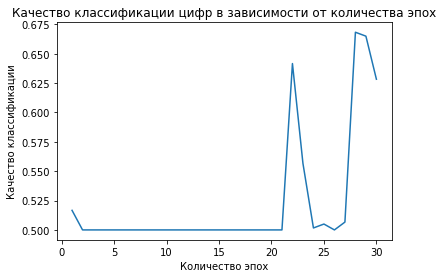

In [26]:
# А теперь посмотрим, как менялось качество в процессе обучения нейронки
from matplotlib import pyplot as plt

plt.plot(list(scores.keys()), list(map(lambda x: x[1], scores.values())))
plt.xlabel("Количество эпох")
plt.ylabel("Качество классификации")
plt.title("Качество классификации цифр в зависимости от количества эпох")
plt.show()

In [27]:
scores

{1: [0.6931943297386169, 0.5166666507720947],
 2: [0.6931787133216858, 0.5],
 3: [0.6931758522987366, 0.5],
 4: [0.6931641101837158, 0.5],
 5: [0.6932064890861511, 0.5],
 6: [0.6930798888206482, 0.5],
 7: [0.6930896043777466, 0.5],
 8: [0.6930685043334961, 0.5],
 9: [0.693016529083252, 0.5],
 10: [0.6930658221244812, 0.5],
 11: [0.6930328011512756, 0.5],
 12: [0.6930128335952759, 0.5],
 13: [0.6929686069488525, 0.5],
 14: [0.6930538415908813, 0.5],
 15: [0.693076491355896, 0.5],
 16: [0.6930626034736633, 0.5],
 17: [0.6931208372116089, 0.5],
 18: [0.6929250955581665, 0.5],
 19: [0.6928316950798035, 0.5],
 20: [0.6925698518753052, 0.5],
 21: [0.6924114227294922, 0.5],
 22: [0.6922448873519897, 0.6416666507720947],
 23: [0.6921518445014954, 0.5566666722297668],
 24: [0.6920218467712402, 0.5016666650772095],
 25: [0.6918123364448547, 0.5049999952316284],
 26: [0.6918375492095947, 0.5],
 27: [0.6911581158638, 0.5066666603088379],
 28: [0.6892495155334473, 0.6683333516120911],
 29: [0.68619

Точность на всех эпохах выше, чем 0.45

# Задание 4. Готовые архитектуры нейросетей

В keras описаны некоторые популярные архитектуры нейросетей. При этом их можно использовать в качестве одного из слоев другой нейросети. В частности, есть готовый класс, в котором описана VGG19 с теми весами, которые мы подгружали из файла (ImageNet).

In [28]:
from keras.applications.vgg19 import VGG19

ready_model = Sequential()
ready_model.add(VGG19(weights='imagenet'))
ready_model.add(Dense(2, activation='softmax')) 
ready_model.compile(optimizer='sgd', loss='categorical_crossentropy')

Изучите, какие нейросети также популярны для классификации изображений. Выберите 2 архитектуры, постройте модели с их использованием, выберите наилучшую по качеству на 20 эпохах и лучшую по скорости обучения.

In [29]:
# решение задания 4
from keras.applications.resnet_v2 import ResNet152V2
m = Sequential()
m.add(ResNet152V2(weights='imagenet'))
m.add(Dense(2, activation='softmax')) 
m.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
m.save_weights(os.path.join(root_dir,'resnet_weights_tf_dim_ordering_tf_kernels.h5'))

242761728/242745792 [==============================] - 2s 0us/step


In [30]:
scores2 = {}
for n_epochs in range(1, 31):  
    m.fit_generator( train_generator, steps_per_epoch=250 // batch_size, epochs=n_epochs, workers=3, initial_epoch=n_epochs-1)
    score = m.evaluate(x=test_generator, workers=3, verbose=0)
    scores2[n_epochs] = score  # сохраним текущее качество, чтобы построить график

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


15/15 [==============================] - 33s 978ms/step - loss: 0.6930 - accuracy: 0.5167
Epoch 2/2
15/15 [==============================] - 15s 977ms/step - loss: 0.6939 - accuracy: 0.5708
Epoch 3/3
15/15 [==============================] - 15s 974ms/step - loss: 0.6925 - accuracy: 0.4917
Epoch 4/4
15/15 [==============================] - 15s 975ms/step - loss: 0.6925 - accuracy: 0.3958
Epoch 5/5
15/15 [==============================] - 15s 977ms/step - loss: 0.6924 - accuracy: 0.4792
Epoch 6/6
15/15 [==============================] - 15s 977ms/step - loss: 0.6906 - accuracy: 0.6750
Epoch 7/7
15/15 [==============================] - 15s 976ms/step - loss: 0.6922 - accuracy: 0.5875
Epoch 8/8
15/15 [==============================] - 15s 975ms/step - loss: 0.6921 - accuracy: 0.5875
Epoch 9/9
15/15 [==============================] - 15s 975ms/step - loss: 0.6914 - accuracy: 0.6333
Epoch 10/10
15/15 [==============================] - 15s 973ms/step - loss: 0.6912 - accuracy: 0.6167
Epoch 11

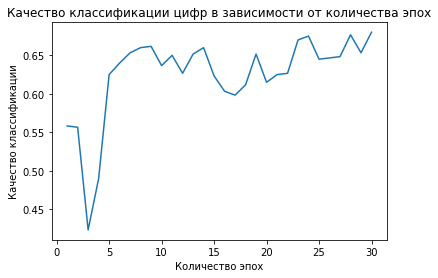

In [32]:
# А теперь посмотрим, как менялось качество в процессе обучения нейронки
plt.plot(list(scores2.keys()), list(map(lambda x: x[1], scores2.values())))
plt.xlabel("Количество эпох")
plt.ylabel("Качество классификации")
plt.title("Качество классификации цифр в зависимости от количества эпох")
plt.show()

In [33]:
scores2

{1: [0.6919525861740112, 0.5583333373069763],
 2: [0.6918318867683411, 0.5566666722297668],
 3: [0.6916103959083557, 0.4233333468437195],
 4: [0.691370964050293, 0.49000000953674316],
 5: [0.6911011934280396, 0.625],
 6: [0.6909691691398621, 0.6399999856948853],
 7: [0.6907796859741211, 0.653333306312561],
 8: [0.6906322836875916, 0.6600000262260437],
 9: [0.690471887588501, 0.6616666913032532],
 10: [0.6903359889984131, 0.6366666555404663],
 11: [0.6900892853736877, 0.6499999761581421],
 12: [0.6899240612983704, 0.6266666650772095],
 13: [0.6897445321083069, 0.6516666412353516],
 14: [0.6894775629043579, 0.6600000262260437],
 15: [0.6892881989479065, 0.6233333349227905],
 16: [0.6891324520111084, 0.6033333539962769],
 17: [0.688940167427063, 0.5983333587646484],
 18: [0.6886616945266724, 0.6116666793823242],
 19: [0.6883581280708313, 0.6516666412353516],
 20: [0.6882074475288391, 0.6150000095367432],
 21: [0.6878955364227295, 0.625],
 22: [0.6876583695411682, 0.6266666650772095],
 23:

In [34]:
from keras.applications.densenet import DenseNet201
m2 = Sequential()
m2.add(DenseNet201(weights='imagenet'))
m2.add(Dense(2, activation='softmax')) 
m2.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
m2.save_weights(os.path.join(root_dir,'densenet201_weights_tf_dim_ordering_tf_kernels.h5'))

82534400/82524592 [==============================] - 1s 0us/step


In [35]:
scores3 = {}
for n_epochs in range(1, 31):  
    m2.fit_generator( train_generator, steps_per_epoch=250 // batch_size, epochs=n_epochs, workers=3, initial_epoch=n_epochs-1)
    score = m2.evaluate(x=test_generator, workers=3, verbose=0)
    scores3[n_epochs] = score  # сохраним текущее качество, чтобы построить график

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


15/15 [==============================] - 36s 667ms/step - loss: 0.6928 - accuracy: 0.4667
Epoch 2/2
15/15 [==============================] - 10s 665ms/step - loss: 0.6938 - accuracy: 0.4417
Epoch 3/3
15/15 [==============================] - 10s 662ms/step - loss: 0.6920 - accuracy: 0.5458
Epoch 4/4
15/15 [==============================] - 10s 661ms/step - loss: 0.6926 - accuracy: 0.5375
Epoch 5/5
15/15 [==============================] - 10s 661ms/step - loss: 0.6913 - accuracy: 0.5542
Epoch 6/6
15/15 [==============================] - 10s 662ms/step - loss: 0.6902 - accuracy: 0.5708
Epoch 7/7
15/15 [==============================] - 11s 664ms/step - loss: 0.6911 - accuracy: 0.5333
Epoch 8/8
15/15 [==============================] - 11s 662ms/step - loss: 0.6908 - accuracy: 0.5625
Epoch 9/9
15/15 [==============================] - 10s 662ms/step - loss: 0.6902 - accuracy: 0.5417
Epoch 10/10
15/15 [==============================] - 10s 664ms/step - loss: 0.6904 - accuracy: 0.5417
Epoch 11

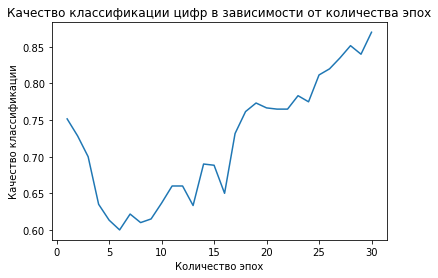

In [36]:
# А теперь посмотрим, как менялось качество в процессе обучения нейронки
plt.plot(list(scores3.keys()), list(map(lambda x: x[1], scores3.values())))
plt.xlabel("Количество эпох")
plt.ylabel("Качество классификации")
plt.title("Качество классификации цифр в зависимости от количества эпох")
plt.show()

In [37]:
scores3

{1: [0.6843169331550598, 0.7516666650772095],
 2: [0.6845118999481201, 0.7283333539962769],
 3: [0.6847460865974426, 0.699999988079071],
 4: [0.6850433945655823, 0.6349999904632568],
 5: [0.6851133108139038, 0.6133333444595337],
 6: [0.6851068735122681, 0.6000000238418579],
 7: [0.6849016547203064, 0.621666669845581],
 8: [0.684799313545227, 0.6100000143051147],
 9: [0.6845270395278931, 0.6150000095367432],
 10: [0.6843374371528625, 0.6366666555404663],
 11: [0.6839643120765686, 0.6600000262260437],
 12: [0.6836562752723694, 0.6600000262260437],
 13: [0.683199405670166, 0.6333333253860474],
 14: [0.6828259825706482, 0.6899999976158142],
 15: [0.6822875142097473, 0.6883333325386047],
 16: [0.6815117001533508, 0.6499999761581421],
 17: [0.6805760860443115, 0.7316666841506958],
 18: [0.6793369650840759, 0.7616666555404663],
 19: [0.6782270073890686, 0.7733333110809326],
 20: [0.6764200329780579, 0.7666666507720947],
 21: [0.6751096844673157, 0.7649999856948853],
 22: [0.6735400557518005, 